# Tohoku Notebook with Random Slip Fields

## Setup Environment

We assume you have installed `anuga` in your `python` environment. 

Some gauge data from  https://www.ngdc.noaa.gov/hazard/dart/2011honshu_dart.html and 
described in NOAA paper https://doi.org/10.1080/19475705.2011.632443. Also data is available from https://github.com/rjleveque/tohoku2011-paper1



### Setup inline graphics and animation

In [67]:
import os
import anuga
import numpy as np
import matplotlib.pyplot as plt
import utm
import okada_kl_subfaults as okl
#from google.colab import files

%matplotlib inline
%load_ext autoreload
%autoreload 2
#%load_ext memory_profiler

# Allow inline jshtml animations
from matplotlib import rc
rc('animation', html='jshtml')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Tohoku Folder

Change into the Tohoku folder (if you have not done that already)

In [68]:
try:
    os.chdir('Tohoku')
except:
    pass
print(f'Current directory {os.getcwd()}')



class Gauge:

    def __init__(self, long, lat, t1=0.0, t2= 1.e10):

        self.lat  = lat
        self.long = long

        self.t1 = t1
        self.t2 = t2

        self.time_series = []
        self.stage_series = []

        import utm

        east, north, zone_no, zone_letter =  utm.from_latlon(self.lat, self.long, force_zone_number=54)

        self.east = east
        self.north = north
        self.zone_no = zone_no
        self.zone_letter = zone_letter


class Gauge_series:

    def __init__(self, gauge, domain):

        self.gauge = gauge
        self.domain = domain

        self.time_series = []
        self.stage_series = []

        self.set_triangle()

    def set_triangle(self):

        domain = self.domain
        gauge = self.gauge
        self.triangle = domain.get_triangle_containing_point([gauge.east, gauge.north])

    def append_stage(self):

        tid = self.triangle
        domain = self.domain

        stage = domain.quantities['stage'].centroid_values[tid]
        time = domain.get_time()

        self.time_series.append(time)
        self.stage_series.append(stage)


gauges = {}

# location of dart buoys
gauges[21401] =  Gauge(152.583, 42.617, t1 = 1800.)
gauges[21413] =  Gauge(152.1167, 30.5153, t1 = 1800.)
#gauges[21414] = [178.281, 48.938,  1800., 1.e10]
#gauges[21415] = [171.849, 50.183,  1800., 1.e10]
#gauges[21416] = [163.505, 48.052,  1800., 1.e10]
gauges[21418] =  Gauge(148.694, 38.711)
gauges[21419] =  Gauge(155.736, 44.455,  t1 = 1800.)
#gauges[51407] = [203.484, 19.642, 22000., 1.e10]
#gauges[52402] = [154.116, 11.883, 10000., 1.e10]

# location of integation points
gauges[0] = Gauge(141.0,38.0)
gauges[1] = Gauge(141.0,38.125)
gauges[2] = Gauge(141.0,38.25)



Current directory /home/steve/Tohoku


### Fault Parameters

In [111]:
# location of epicentre (absolute coordinates)
#x0 = 300000.0
#y0 = 250000.0
x0 = 720*km
y0 = 4200*km

km = 1000.0

# parameters of fault
parameters_small = dict(
    depth=15*km,
    length=100*km,
    width=30*km,
    strike=190.0,
    dip=15.0,
    rake=90.0,
    slip=30.0,
    opening=0.0,
    nu=0.25,
)


parameters = dict(
    depth=20*km,
    length=250*km,
    width=60*km,
    strike=195.0,
    dip=14.0,
    rake=87.0,
    slip=40.0,
    opening=0.0,
    nu=0.25,
)



In [70]:
# setup KL field and sampling method

In [71]:
# draw a sample from the generating method
# create associated deformation

# new deformations Uz will be possible by just running this cell again

## Setup Anuga Model

### Project parameters

In [72]:
import project


In [82]:
def create_domain():

    import project
    print ('project name: ', project.name_stem)

    domain = anuga.create_domain_from_regions(project.bounding_polygon,
                                            boundary_tags={'bottom': [0],
                                                        'ocean_east': [1],
                                                        'top': [2],
                                                        'onshore': [3]},
                                            maximum_triangle_area=project.res_whole,
                                            mesh_filename=project.meshname,
                                            interior_regions=project.interior_regions,
                                            use_cache=False,
                                            verbose=False)



    domain.set_hemisphere('northern')
    domain.set_zone(54)
    
    print ('Number of triangles = ', len(domain))
    print ('The extent is ', domain.get_extent())
    print ('Geo reference is ',domain.geo_reference)

    domain.set_quantity('elevation',
                            filename=project.name_stem + '.pts',
                            use_cache=True,
                            verbose=False,
                            alpha=0.1)

    domain.set_name('tohoku_source_example')


    #tide = -0.45
    tide = 0.0
    domain.set_quantity('stage', tide)

    Elevation = domain.quantities['elevation'].centroid_values
    Stage     = domain.quantities['stage'].centroid_values

    Stage[:] = np.maximum(Elevation, Stage)

    return domain

def apply_deformation(domain, z, parameters, x0, y0):

    # x,y and x_off, y_off are in UTM coordinates or relative to the domain
    x = domain.centroid_coordinates[:,0] # relative
    y = domain.centroid_coordinates[:,1] # relative

    xll = domain.geo_reference.xllcorner
    yll = domain.geo_reference.yllcorner

    xoff = x0 - xll
    yoff = y0 - yll

    

    uE,uN,uZ, _ = okl.kl_deformation(x, y, xoff=xoff, yoff=yoff, E_subfault=E_subfault, N_subfault=N_subfault, 
                                    sample=z, iseed=1234, **parameters)


    Elevation = domain.quantities['elevation'].centroid_values
    Stage     = domain.quantities['stage'].centroid_values

    print ('Stage extent (orig)',np.max(Stage), np.min(Stage))

    Elevation[:] = Elevation + uZ
    Stage[:]     = Stage + uZ

    print ('uZ extent          ',np.max(uZ), np.min(uZ))

    print ('Stage extent       ',np.max(Stage), np.min(Stage))
    print ('Elevation extent   ',np.max(Elevation), np.min(Elevation))

def evolve_domain(domain):

    # Setup boundaries
    Br = anuga.Reflective_boundary(domain)
    Bf = anuga.Flather_external_stage_zero_velocity_boundary(domain,lambda t :tide)
    # Boundary conditions
    domain.set_boundary({'onshore': Br,
                            'bottom': Bf,
                            'ocean_east': Bf,
                            'top': Bf})


    from anuga.operators.collect_max_quantities_operator import Collect_max_quantities_operator
    max_min_collector = Collect_max_quantities_operator(domain)

    tide = 0.0

    # Evolve system through time
    import time
    t0 = time.time()
    min = 60.
    hour = 3600.

    
    gauge_series = {}

    for key in [21418, 0, 1, 2]:
        gauge_series[key] = Gauge_series(gauges[key], domain)





    # Initial run without any event
    for t in domain.evolve(yieldstep=2*min, finaltime=2.0*hour):

        for key in [21418, 0, 1, 2]:
            gauge_series[key].append_stage()

        domain.print_timestepping_statistics()

    print ('That took %.2f seconds' %(time.time()-t0))

    return gauge_series, max_min_collector



### View Mesh and Elevation

Figure files for each frame will be stored in _plot


Text(0.5, 1.0, 'Elevation (Bathymetry) east coast Japan')

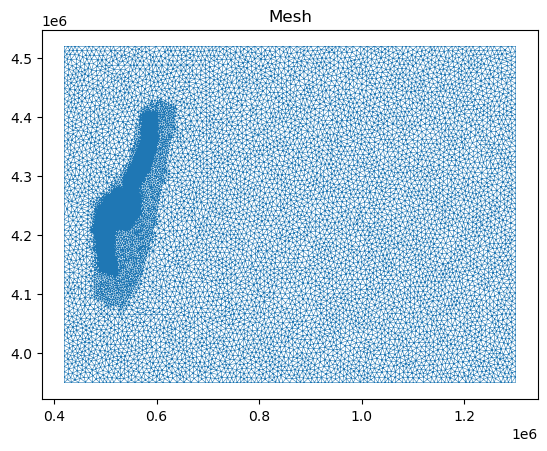

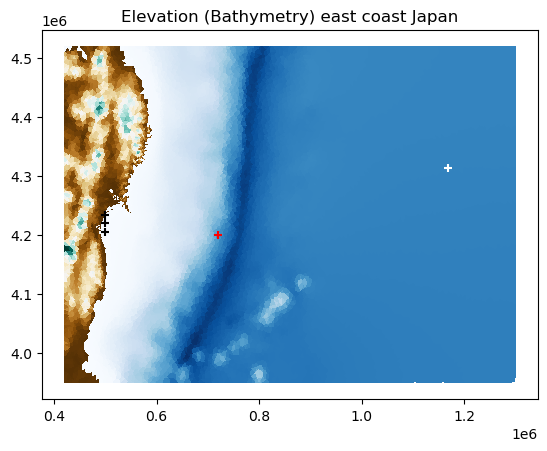

In [74]:
domain = create_domain()  


dplotter = anuga.Domain_plotter(domain, absolute=True)
plt.triplot(dplotter.triang, linewidth = 0.4)
plt.title('Mesh')

import cartopy
import cartopy.crs as ccrs

fig = plt.figure()
#ax = fig.add_subplot(111, projection=ccrs.UTM(zone=54))
ax = fig.add_subplot(111)

# Test for dry areas
md = 0.01

# Dry areas
dplotter.triang.set_mask(dplotter.depth > md)
ax.tripcolor(dplotter.triang,
                      facecolors=dplotter.elev,
                      cmap='BrBG')
                      #cmap='viridis_r')
                      #cmap='Greys_r')

# Wet Areas
dplotter.triang.set_mask(dplotter.depth <= md)
ax.tripcolor(dplotter.triang,
                      facecolors=dplotter.elev,
                      cmap='Blues_r')
                      #cmap='viridis')
                      #vmin=vmin, vmax=vmax)

dplotter.triang.set_mask(None)

# plot epicentre (absolute)

ax.scatter(x0, y0, marker='+', color='r')

# dart 21418 location 
ax.scatter(gauges[21418].east, gauges[21418].north, marker='+', color='w')

# locations on coast
ax.scatter(gauges[0].east, gauges[0].north, marker='+', color='k')
ax.scatter(gauges[1].east, gauges[1].north, marker='+', color='k')
ax.scatter(gauges[2].east, gauges[2].north, marker='+', color='k')

# for gauge_no, gauge_data in gauges.items():
#     print(gauge_no, gauge_data.east, gauge_data.north)
#     ax.scatter(gauge_data.east, gauge_data.north, marker='+', color='r')

# plot dart location



#ax.set_extent([450000,2000000,4000000, 4400000], crs=ccrs.UTM(zone=54))
#gridlines = ax.gridlines(draw_labels=True)

#ax.coastlines()

plt.title('Elevation (Bathymetry) east coast Japan')

#plt.colorbar()



### Setup random or QMC samplers

In [83]:
# we need to come up with a way to generate difference samples when running the notebook a second time. 
# Need a loop to generate the samples and then run the simulation for each sample.

from math import exp, sqrt
#from numpy import linalg as LA
from scipy.stats import qmc

sample = 'random'
iseed = None
#sample = 'sobol'
#sample = None

E_subfault = 10
N_subfault = 10

# number of KL terms
N = E_subfault*N_subfault

if sample == 'sobol':
    sampler = qmc.Sobol(d=N, scramble=True, seed=iseed)
    
if sample == 'random':
    if iseed is not None:
        np.random.seed(iseed)
    sampler = np.random.default_rng()





### Create sample and create tsunami source

In [105]:
if sample == 'sobol':
    z = (sampler.random()).reshape((N,1))

if sample == 'random':
    z = (sampler.standard_normal(N)).reshape((N,1))



domain = create_domain()  

apply_deformation(domain, z, parameters, x0, y0)


project name:  Tohoku
Number of triangles =  26587
The extent is  (0.0, 880000.0, 0.0, 570000.0)
Geo reference is  (zone=54, easting=420000.000000, northing=3950000.000000, hemisphere=northern)
Stage extent (orig) 1386.5451575209129 0.0
uZ extent           20.06975712710467 -7.688290559281493
Stage extent        1386.5611060411388 -7.688290559281493
Elevation extent    1386.5611060411388 -7861.4352816348655


### View Stage after source has been applied

Figure files for each frame will be stored in _plot


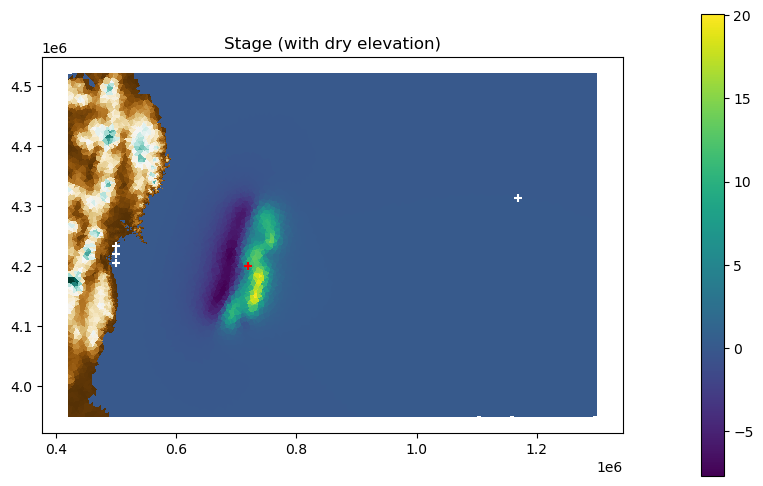

In [106]:
dplotter = anuga.Domain_plotter(domain, absolute=True)
# plt the updated elevation and stage
fig = plt.figure(figsize=(10,10))
#ax = fig.add_subplot(111, projection=ccrs.UTM(zone=54))
ax = fig.add_subplot(111)

md = 0.01

# dry areas
dplotter.triang.set_mask(dplotter.depth > md)
ax.tripcolor(dplotter.triang,
                      facecolors=dplotter.elev,
                      cmap='BrBG')
                      #cmap='viridis_r')
                      #cmap='Greys_r')


# wet areas
dplotter.triang.set_mask(dplotter.depth <= md)
img = ax.tripcolor(dplotter.triang,
                      facecolors=dplotter.stage,
                      #cmap='Blues_r')
                      cmap='viridis')
                      #vmin=vmin, vmax=vmax)

ax.set_aspect('equal', adjustable='box')

#fig.colorbar(img, pad = 0.2, shrink=0.6)
fig.colorbar(img, ax=ax, orientation='vertical', pad = 0.1, shrink=0.6)

ax.scatter(x0,y0,marker='+', color='r')

ax.scatter(gauges[21418].east, gauges[21418].north, marker='+', color='w')
ax.scatter(gauges[0].east, gauges[0].north, marker='+', color='w')
ax.scatter(gauges[1].east, gauges[1].north, marker='+', color='w')
ax.scatter(gauges[2].east, gauges[2].north, marker='+', color='w')

#ax.set_extent([400000,2500000,4000000, 4400000], crs=ccrs.UTM(zone=54))
#gridlines = ax.gridlines(draw_labels=True)



#ax.coastlines()

plt.title('Stage (with dry elevation)');

### Evolve the simulation

In [107]:
gauge_series, max_min_collector = evolve_domain(domain)

/home/steve/anuga_core/anuga/shallow_water/boundaries.py:1161: RuntimeWarning: invalid value encountered in multiply
  w1 = 0.0 - sqrt_g_on_depth_inside * stage_outside
/home/steve/anuga_core/anuga/shallow_water/boundaries.py:1165: RuntimeWarning: invalid value encountered in divide
  (n2 * Xmom.boundary_values[ids] - n1 * Ymom.boundary_values[ids])/depth_inside,
/home/steve/anuga_core/anuga/shallow_water/boundaries.py:1168: RuntimeWarning: invalid value encountered in divide
  w3 = ndotq_inside/depth_inside + sqrt_g_on_depth_inside*Stage.boundary_values[ids]


Time = 0.0000 (sec), steps=0 (16s)
Time = 120.0000 (sec), delta t in [4.04872003, 4.05196231] (s), steps=30 (0s)
Time = 240.0000 (sec), delta t in [4.04854095, 4.05190993] (s), steps=30 (0s)
Time = 360.0000 (sec), delta t in [4.05155251, 4.05182318] (s), steps=30 (0s)
Time = 480.0000 (sec), delta t in [4.05168987, 4.05191328] (s), steps=30 (0s)
Time = 600.0000 (sec), delta t in [4.05191361, 4.05196547] (s), steps=30 (0s)
Time = 720.0000 (sec), delta t in [4.05187828, 4.05191234] (s), steps=30 (0s)
Time = 840.0000 (sec), delta t in [4.05187850, 4.05199413] (s), steps=30 (0s)
Time = 960.0000 (sec), delta t in [4.05199767, 4.05213137] (s), steps=30 (0s)
Time = 1080.0000 (sec), delta t in [4.05196908, 4.05201939] (s), steps=30 (0s)
Time = 1200.0000 (sec), delta t in [4.05194421, 4.05202099] (s), steps=30 (0s)
Time = 1320.0000 (sec), delta t in [4.05191146, 4.05194201] (s), steps=30 (0s)
Time = 1440.0000 (sec), delta t in [4.05191523, 4.05196040] (s), steps=30 (0s)
Time = 1560.0000 (sec), d

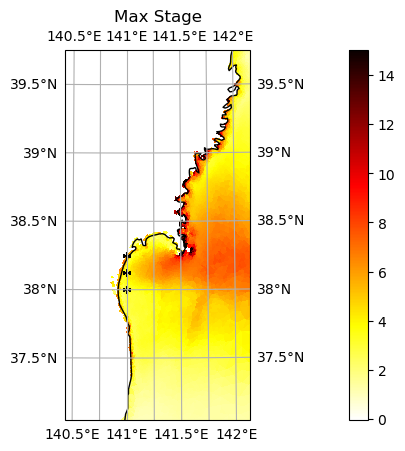

In [108]:
max_depth = max_min_collector.max_depth
max_stage = max_min_collector.max_stage

wet_mask = max_depth >= 0.01

wet_max_stage = np.where(max_depth >= 0.01, max_stage, np.nan)

fig = plt.figure()
ax = fig.add_subplot(111, projection=ccrs.UTM(zone=54))
#ax = fig.add_subplot(111)



img = ax.tripcolor(dplotter.triang,
                      facecolors=wet_max_stage,
                      #cmap='BrBG')
                      #cmap='viridis_r')
                      cmap='hot_r',
                      vmax=15.0)
                      #cmap='Greys_r')


# plot epicentre (absolute)
x0 = 720000.0
y0 = 4200000.0
ax.scatter(x0, y0, marker='+', color='r')

# dart 21418 location 
ax.scatter(gauges[21418].east, gauges[21418].north, marker='+', color='w')

# locations on coast
ax.scatter(gauges[0].east, gauges[0].north, marker='+', color='k')
ax.scatter(gauges[1].east, gauges[1].north, marker='+', color='k')
ax.scatter(gauges[2].east, gauges[2].north, marker='+', color='k')




ax.set_extent([450000,600000,4100000, 4400000], crs=ccrs.UTM(zone=54))
gridlines = ax.gridlines(draw_labels=True)

ax.coastlines()

plt.title('Max Stage')
plt.colorbar(img, pad = 0.2, shrink=1.0)



In [109]:
#dplotter.make_stage_animation()

Text(0.5, 1.0, 'Comparison with 21418 data')

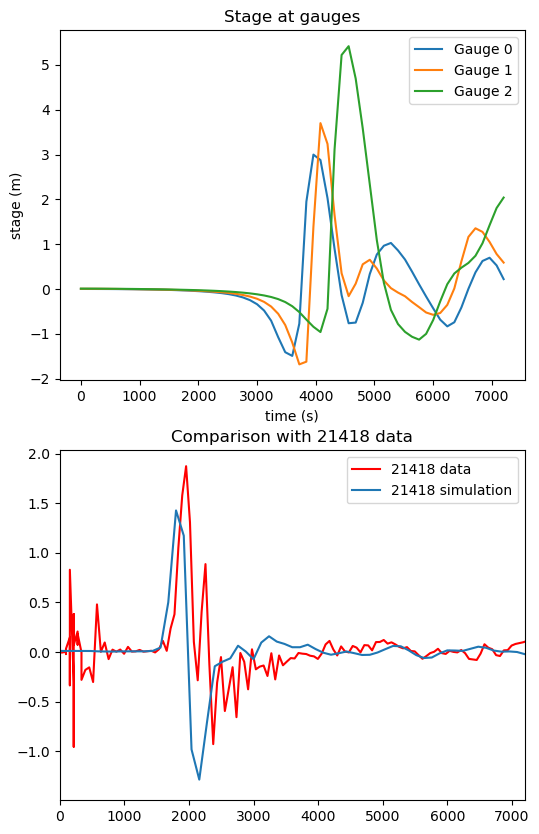

In [110]:
t = gauge_series[21418].time_series
stage_21418 = gauge_series[21418].stage_series
stage_0 = gauge_series[0].stage_series
stage_1 = gauge_series[1].stage_series
stage_2 = gauge_series[2].stage_series

# stage_21418 = np.array(gauge_21418_stage)
# stage_0 = np.array(gauge_0_stage)
# stage_1 = np.array(gauge_1_stage)
# stage_2 = np.array(gauge_2_stage)

# t = np.array(gauge_time)
# stage_21418 = np.array(gauge_21418_stage)
# stage_0 = np.array(gauge_0_stage)
# stage_1 = np.array(gauge_1_stage)
# stage_2 = np.array(gauge_2_stage)

fig = plt.figure(figsize=(6,10))
#fig = plt.figure()



ax = fig.add_subplot(211)

ax.plot(t, stage_0, label='Gauge 0')
ax.plot(t, stage_1, label='Gauge 1')
ax.plot(t, stage_2, label='Gauge 2')

ax.set_xlabel('time (s)')
ax.set_ylabel('stage (m)')  
ax.legend()
ax.set_title('Stage at gauges')

ax = fig.add_subplot(212)
hour = 3600.0
xy = np.loadtxt('21418_notide.txt')

ax.plot(xy[:,0], xy[:,1], 'r', label='21418 data') 
ax.plot(t, stage_21418, label='21418 simulation')
ax.legend()
ax.set_xlim(0, 2*hour)
ax.set_title('Comparison with 21418 data')

In [16]:
# splotter = anuga.SWW_plotter('tohoku_source_example.sww')

# wet_mask = splotter.depth >= 0.01

# wet_stage = np.where(splotter.depth >= 0.01, splotter.stage, np.nan)

# wet_max_stage = np.nanmax(wet_stage, axis=0)

# wet_max_stage.shape


In [17]:
# fig = plt.figure()
# ax = fig.add_subplot(111, projection=ccrs.UTM(zone=54))
# #ax = fig.add_subplot(111)



# img = ax.tripcolor(dplotter.triang,
#                       facecolors=wet_max_stage,
#                       #cmap='BrBG')
#                       cmap='hot_r')
#                       #cmap='viridis_r')
#                       #cmap='Greys_r')


# # plot epicentre (absolute)
# x0 = 720000.0
# y0 = 4200000.0
# ax.scatter(x0, y0, marker='+', color='r')

# # dart 21418 location 
# ax.scatter(gauges[21418].east, gauges[21418].north, marker='+', color='w')

# # location on coast
# ax.scatter(gauges[0].east, gauges[0].north, marker='+', color='b')

# ax.scatter(gauges[1].east, gauges[1].north, marker='+', color='k')




# #ax.set_extent([450000,2000000,4000000, 4400000], crs=ccrs.UTM(zone=54))
# gridlines = ax.gridlines(draw_labels=True)

# #ax.coastlines()

# plt.title('Max Wet Stage')

# plt.colorbar(img, pad = 0.2, shrink=0.64)


In [21]:

from scipy.stats import qmc
N = 100
sobol_sampler = qmc.Sobol(d=N, scramble=True, seed=None)
z = (sobol_sampler.random()).reshape((N,1))

In [22]:
z.shape

(100, 1)